<a href="https://colab.research.google.com/github/hejazn86/Sunspot_prediction/blob/master/sunspot_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
#loading the data as a list and converting it to a numpy array
import os
import csv
import numpy

time_steps = []
sunspots = []
path = '/drive/My Drive/datasets_2418_917074_Sunspots.csv'
with open(path) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for col in reader:
    sunspots.append(float(col[2]))
    time_steps.append(int(col[0]))

print(sunspots)
import numpy as np

series = np.array(sunspots)
time = np.array(time_steps) 

print(series.shape)
print(series)

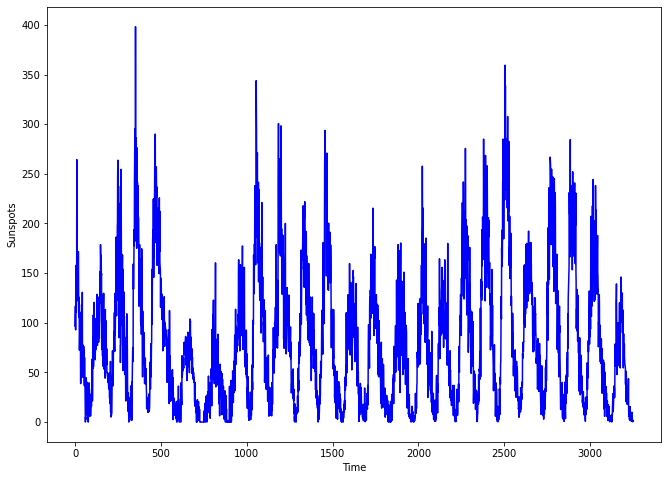

In [ ]:
#plotting the data

import matplotlib.pyplot as plt
 
plt.figure(figsize=(11, 8))
plt.plot(time, series, 'b')
plt.xlabel('Time')
plt.ylabel('Sunspots')
plt.show()

In [ ]:
# splitting the data to train and validation sets

split_time = 2500
train_time =time[:split_time]
x_train = series[:split_time]
test_time = time[split_time:]
x_test = series[split_time:]

window_size = 30
batch_size = 64
shuffle_buffer_size = 100

# prepare the dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [ ]:
# building a model to predict

import tensorflow as tf

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal', strides=1, input_shape=[None, 1]),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)                            
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-4), metrics=['mae'])

history = model.fit(dataset, epochs=100)

In [ ]:
# forcasting (testing the model)

estimated = []
for time in range(len(series) - window_size):
  estimated.append(model.predict(series[time:time + window_size][np.newaxis]))

estimated = estimated[split_time-window_size:]
result = np.array(estimated)[:, 0, 0]


plt.figure(figsize=(11, 8))
plt.plot(test_time, x_test, 'b*', label='real_data')
plt.plot(test_time, result, 'ro', label='predicted')
